<a href="https://colab.research.google.com/github/budennovsk/Pandas/blob/master/timesfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# !git clone https://github.com/google-research/timesfm.git
# %cd timesfm
# !pip install .


In [31]:
!pip install utilsforecast

In [32]:
from google.colab import drive
import warnings

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


import pandas as pd

# Подавление предупреждений о сходимости
warnings.filterwarnings("ignore")


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


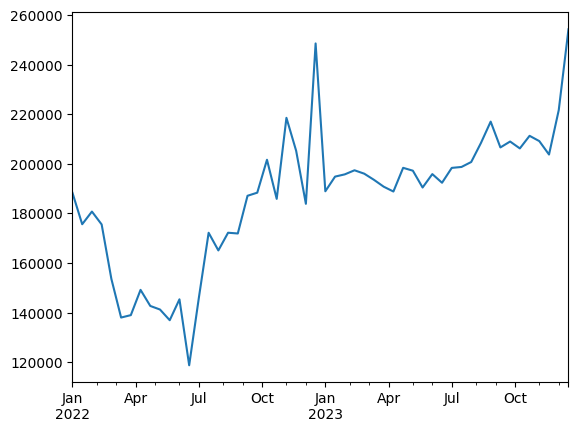

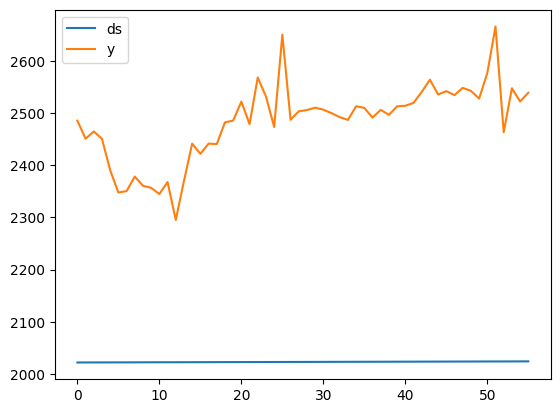

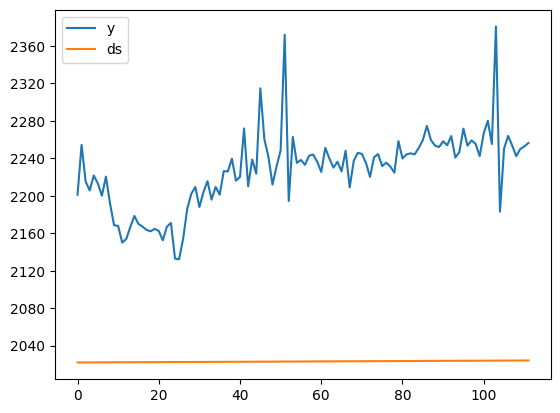

In [69]:
# path_csv_red = '/content/drive/MyDrive/Colab Notebooks/zvezda/Server_zvezda/Dataset/series_data.csv'
end_train = '2023-12-24 23:59:59'
path_csv_red = '/content/drive/MyDrive/Colab Notebooks/zvezda/Server_zvezda/Dataset/ts2024.csv'

path_csv_freq_W = '/content/drive/MyDrive/Colab Notebooks/zvezda/Server_zvezda/Dataset/Week_SALES_VOL.xlsx'



# Читаем данные из CSV файла в DataFrame
df = pd.read_csv(path_csv_red)
df_W = pd.read_excel(path_csv_freq_W)


# Преобразуем один из столбцов DataFrame в pd.Series
series_data = df['SALES VOL']  # Замените 'column_name' на имя столбца, содержащего данные
date_idx = pd.date_range(start='2022-01-01', periods=56,freq='2W-SUN')
series_data.index = date_idx
series_data_org = series_data.copy()
series_data = series_data[:end_train].copy()

#WEEK

df_W['y']= df_W['SALES VOL'].values  # Замените 'column_name' на имя столбца, содержащего данные
df_W['ds']= pd.date_range(start='2022-01-01', periods=112,freq='W')
df_week= df_W.drop(df_W.columns.tolist()[:-2],axis=1)
temp_W = df_week.copy()





temps=pd.DataFrame()
temps['ds']=series_data_org.index
temps['y']=series_data_org.values

series_data.plot(label='series')
temps.plot(label='dataframe')
temp_W.plot()

plt.legend()
plt.show()


In [34]:
import timesfm
tfm = timesfm.TimesFm(
    context_len=480,
    horizon_len=14,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu",
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 6.89 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 8.48 seconds.
Jitting decoding.
Jitted decoding in 45.24 seconds.


In [89]:
# def predict_total_guests_fm(data, initial_window_size, step_size):
#     data['unique_id'] = 0
#     window_size = initial_window_size
#     predictions = pd.Series()

#     prediction = tfm.forecast_on_df(data[:105], freq="W", value_name='y')['timesfm']

#     # predictions = pd.concat([predictions, prediction])
#     # window_size += step_size


#     # supp = len(predictions) - (window_size - initial_window_size)
#     # predictions = predictions[:-supp]
#     # predictions.index = [i for i in range(initial_window_size, window_size)]
#     return prediction

In [123]:
def predict_total_guests_fm(data, initial_window_size, step_size):
    data['unique_id'] = 0
    window_size = initial_window_size
    predictions = pd.Series()
    while window_size < len(data):

        prediction = tfm.forecast_on_df(data[:105], freq="W", value_name='y')['timesfm']
        print(prediction)
        predictions = pd.concat([predictions, prediction])
        window_size += step_size
    supp = len(predictions) - (window_size - initial_window_size)
    predictions = predictions[:-supp]
    predictions.index = [i for i in range(initial_window_size, window_size)]
    return predictions

In [124]:
%%capture
predictions_fm = predict_total_guests_fm(temp_W, initial_window_size=24, step_size=2)
predictions_fm.index= pd.date_range(start='2024-01-01', periods=len(predictions_fm),freq='W')
print(predictions_fm)

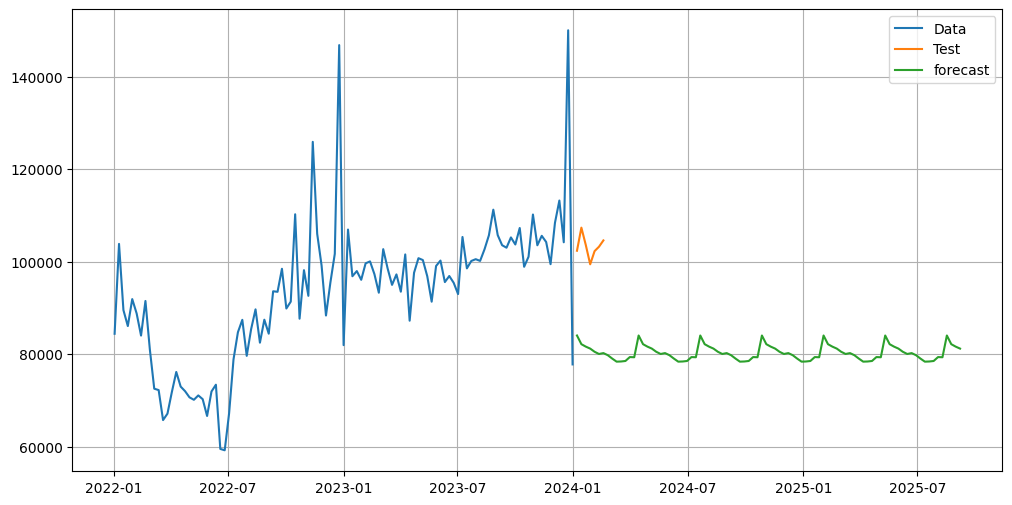

In [125]:
plt.figure(figsize=(12,6))
plt.plot(temp_W['ds'][:105].values,temp_W['y'][:105].values, label='Data')
plt.plot(temp_W['ds'][105:].values,temp_W['y'][105:].values, label='Test')
plt.plot(predictions_fm, label='forecast')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
hern9